### 0. Imports and requirements

* В данном соревновании мы имеем дело с последовательностями, один из интуитивных способов работы с ними &ndash; использование рекуррентных нейронных сетей. В этом базовом решении мы демонстрируем, как можно построить хорошее решение задачи соревнования без использования сложного и трудоемкого feature engineering'а (чтобы эффективно решать ту же задачу с высоким качеством с помощью бустингов нужно несколько тысяч признаков), благодаря рекуррентным нейронным сетям. В этом ноутбуке мы построим решение с использованием фреймфорка `torch`. Для комфортной работы Вам понадобится машина с `GPU` (хватит ресурсов `google colab` или `kaggle`).

In [1]:
! git clone https://github.com/SmirnovValeriy/dl-fintech-bki.git

Cloning into 'dl-fintech-bki'...
remote: Enumerating objects: 26, done.
remote: Counting objects: 100% (10/10), done.
remote: Compressing objects: 100% (10/10), done.
remote: Total 26 (delta 2), reused 4 (delta 0), pack-reused 16
Receiving objects: 100% (26/26), 16.23 MiB | 7.36 MiB/s, done.
Resolving deltas: 100% (4/4), done.


In [2]:
! wget https://storage.yandexcloud.net/ds-ods/files/materials/3c36dbad/train_target.csv
! wget https://storage.yandexcloud.net/ds-ods/files/materials/f020b5d6/train_data.zip
! wget https://storage.yandexcloud.net/ds-ods/files/materials/f2d2379a/test_data.zip

--2024-08-05 04:44:40--  https://storage.yandexcloud.net/ds-ods/files/materials/3c36dbad/train_target.csv
Resolving storage.yandexcloud.net (storage.yandexcloud.net)... 213.180.193.243, 2a02:6b8::1d9
Connecting to storage.yandexcloud.net (storage.yandexcloud.net)|213.180.193.243|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 28888898 (28M) [text/csv]
Saving to: ‘train_target.csv’

train_target.csv    100%[===================>]  27.55M  8.60MB/s    in 3.2s    

2024-08-05 04:44:45 (8.60 MB/s) - ‘train_target.csv’ saved [28888898/28888898]

--2024-08-05 04:44:45--  https://storage.yandexcloud.net/ds-ods/files/materials/f020b5d6/train_data.zip
Resolving storage.yandexcloud.net (storage.yandexcloud.net)... 213.180.193.243, 2a02:6b8::1d9
Connecting to storage.yandexcloud.net (storage.yandexcloud.net)|213.180.193.243|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 319405083 (305M) [application/x-zip-compressed]
Saving to: ‘train_data.zip’


In [3]:
! unzip /content/train_data.zip
! unzip /content/test_data.zip

Archive:  /content/train_data.zip
  inflating: train_data/train_data_0.pq  
  inflating: train_data/train_data_1.pq  
  inflating: train_data/train_data_10.pq  
  inflating: train_data/train_data_11.pq  
  inflating: train_data/train_data_2.pq  
  inflating: train_data/train_data_3.pq  
  inflating: train_data/train_data_4.pq  
  inflating: train_data/train_data_5.pq  
  inflating: train_data/train_data_6.pq  
  inflating: train_data/train_data_7.pq  
  inflating: train_data/train_data_8.pq  
  inflating: train_data/train_data_9.pq  
Archive:  /content/test_data.zip
  inflating: test_data/test_data_0.pq  
  inflating: test_data/test_data_1.pq  


In [1]:
%load_ext autoreload
%autoreload 2

import os
import pandas as pd
import sys
import pickle
import numpy as np
import torch
import torch.nn as nn

from sklearn.model_selection import train_test_split
import tqdm

import matplotlib.pyplot as plt


pd.set_option("display.max_columns", None)
plt.style.use("seaborn-pastel")

# добавим родительскую директорию, в ней лежат все необходимые полезные функции для обработки данных
sys.path.append("../")

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


<ipython-input-1-70770cdcb8fd>:19: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn-pastel")


### 1. Data Preprocessing

In [4]:
TRAIN_DATA_PATH = "/content/train_data/"
TEST_DATA_PATH = "/content/test_data/"

TRAIN_TARGET_PATH = "/content/train_target.csv"

In [5]:
train_target = pd.read_csv(TRAIN_TARGET_PATH)

* Как и в случае с бустингами, мы не можем поместить всю выборку в память ввиду, например, ограниченных ресурсов. Для итеративного чтения данных нам потребуется функция `utils.read_parquet_dataset_from_local`, которая читает N частей датасета за раз в память.


* Нейронные сети требуют отдельного внимания к тому, как будут предобработаны и поданы данные. Важные моменты, на которые требуется обратить внимание:
    1. Использование рекуррентных сетей подразумевает работу на уровне последовательностей, где одна последовательность &ndash; все исторические кредиты клиента. Чтобы преобразовать `pd.DataFrame` с записями из кредитных историй клиентов в табличном виде к последовательностям, мы подготовили функцию `dataset_preprocessing_utils.transform_credits_to_sequences`, она производит необходимые манипуляции и возвращает фрейм с двумя колонками: `id` и `sequences`. Колонка `sequences` представляет из себя список списков длины `len(features)`, где каждый вложенный список &ndash; значения одного конкретного признака во всех кредитах клиента.
    
    2. Клиенты могут иметь различные по длине кредитные истории. При этом обучение нейронных сетей происходит батчами и поскольку рекуррентные слои не способны обрабатывать батчи с последовательностями  неодинаковой длины, существует несколько подходов для приведения последовтельностей в батче к удобоваримому виду. Простой подход заключается в дополнении более коротких последовательностей нулями до максимальной длины последовательности в батче (т. н. паддинг). Довольно неэффективно делать паддинг внутри батча на последовательностях случайной длины (часто будем делать большой и бесполезный паддинг). Гораздо лучше использовать технику `Sequence Bucketing` (о ней мы рассказываем в нашем треке). Для реализации паддинга последовательностей кредитов клиентов мы подготовили функцию `dataset_preprocessing_utils.create_padded_buckets`.

In [6]:
%cd /content/dl-fintech-bki
from utils import read_parquet_dataset_from_local
from rnn_baseline.dataset_preprocessing_utils import features, transform_credits_to_sequences, create_padded_buckets

/content/dl-fintech-bki


* В дальнейшем при построении рекуррентной нейронной сети нам понадобятся следующие статистики по тренировочной и тестовой выборкам: распределение длин кредитных историй и число уникальных значений каждого категориального значения. Посчитаем эти статистики:

In [ ]:
import os
import gc
import pandas as pd
import numpy as np
from collections import defaultdict
import tqdm
import pickle

In [3]:
def process_data_in_chunks(path, steps, chunk_size, output_dir, description):
    uniques = defaultdict(set)
    seq_lens = []

    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    for step in tqdm.notebook.tqdm(range(0, steps, chunk_size), desc=description):
        # Загрузка данных
        credits_frame = read_parquet_dataset_from_local(path, step, chunk_size, verbose=True)
        chunk_seq_lens = credits_frame.groupby("id").agg(seq_len=("rn", "max"))["seq_len"].values
        seq_lens.extend(chunk_seq_lens)
        credits_frame.drop(columns=["id", "rn"], inplace=True)

        # Сохранение промежуточных данных на диск
        chunk_filename = os.path.join(output_dir, f"chunk_{step}_{step+chunk_size}.pkl")
        with open(chunk_filename, "wb") as f:
            pickle.dump(credits_frame, f)

        # Обновление уникальных значений
        for feat in credits_frame.columns.values:
            uniques[feat] = uniques[feat].union(credits_frame[feat].unique())

        # Очистка памяти
        del credits_frame
        gc.collect()

    return np.hstack(seq_lens), dict(uniques)

train_data_path = "/content/train_data/"
test_data_path = "/content/test_data/"
train_output_dir = "/content/train_chunks/"
test_output_dir = "/content/test_chunks/"

train_lens, train_uniques = process_data_in_chunks(train_data_path, 12, 1, train_output_dir, "Count statistics on train data")
test_lens, test_uniques = process_data_in_chunks(test_data_path, 2, 1, test_output_dir, "Count statistics on test data")

uniques = defaultdict(set, {**train_uniques, **test_uniques})

Count statistics on train data:   0%|          | 0/12 [00:00<?, ?it/s]

NameError: name 'TRAIN_DATA_PATH' is not defined

* Чтобы сразу убедиться, что посчитанные статистики интересные и полезные, построим графики распределений длин кредитных историй в тренировочной и тестовой выборках

In [7]:
from collections import Counter


train_len_counter = pd.Series(Counter(train_lens)).sort_index()
test_len_counter = pd.Series(Counter(test_lens)).sort_index()

<BarContainer object of 0 artists>

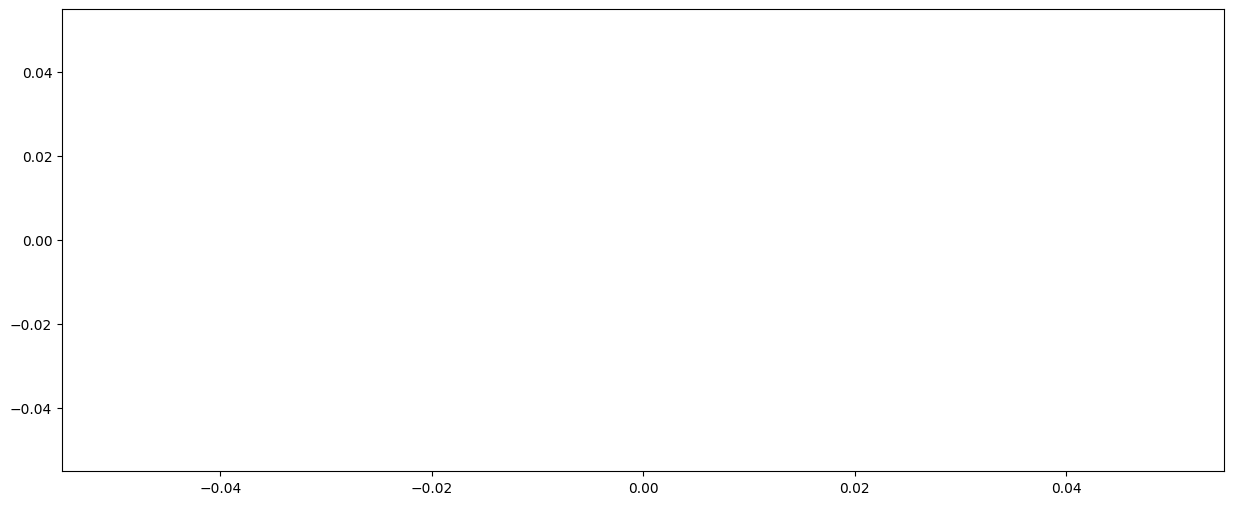

In [8]:
fig, ax = plt.subplots(figsize=(15, 6), nrows=1)
ax.bar(train_len_counter.index.values, train_len_counter.values)

<BarContainer object of 50 artists>

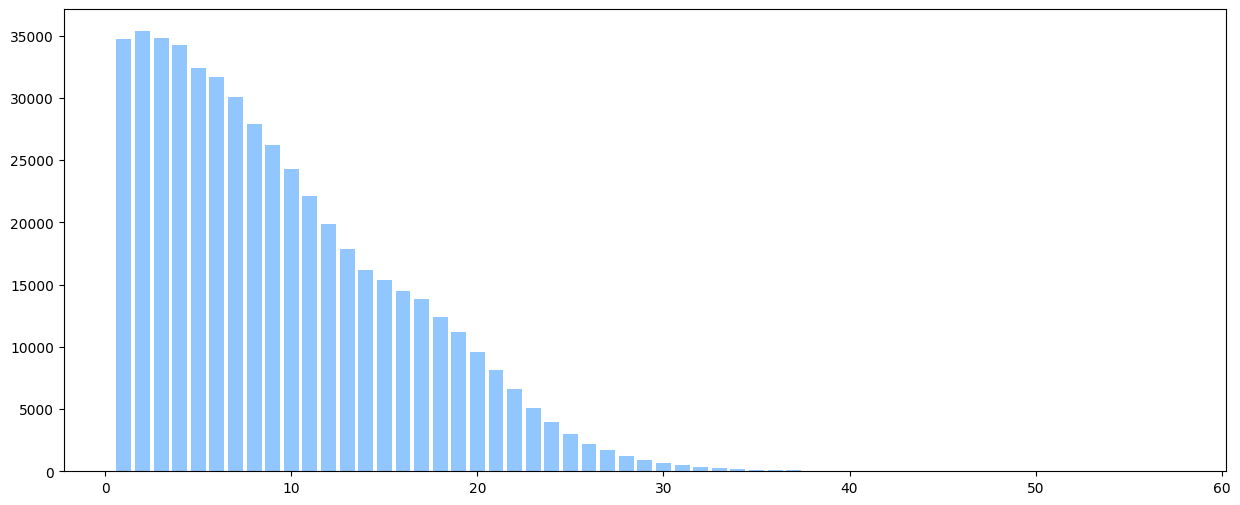

In [8]:
fig, ax = plt.subplots(figsize=(15, 6), nrows=1)
ax.bar(test_len_counter.index.values, test_len_counter.values)

In [9]:
train_lens.max(), test_lens.max()

(58, 57)

* Один из аргументов в функции `dataset_preprocessing_utils.create_padded_buckets` &ndash; `bucket_info` &ndash; словарь, где для конкретной длины последовательности указано до какой длины нужно делать паддинг. Для данного бэйзлайна возьмем простое разбиение на 43 бакета:
| Длина последовательности | Длина после паддинга |
| :-: | :-:
| 1 &ndash; 40 | без изменений |
| 41 &ndash; 45 | 45 |
| 46 &ndash; 50 | 50 |
| 51 &ndash; 58 | 58 |

In [15]:
keys_ = list(range(1, 59))
lens_ = list(range(1, 41)) + [45] * 5 + [50] * 5 + [58] * 8
bucket_info = dict(zip(keys_, lens_))
bucket_info

{1: 1,
 2: 2,
 3: 3,
 4: 4,
 5: 5,
 6: 6,
 7: 7,
 8: 8,
 9: 9,
 10: 10,
 11: 11,
 12: 12,
 13: 13,
 14: 14,
 15: 15,
 16: 16,
 17: 17,
 18: 18,
 19: 19,
 20: 20,
 21: 21,
 22: 22,
 23: 23,
 24: 24,
 25: 25,
 26: 26,
 27: 27,
 28: 28,
 29: 29,
 30: 30,
 31: 31,
 32: 32,
 33: 33,
 34: 34,
 35: 35,
 36: 36,
 37: 37,
 38: 38,
 39: 39,
 40: 40,
 41: 45,
 42: 45,
 43: 45,
 44: 45,
 45: 45,
 46: 50,
 47: 50,
 48: 50,
 49: 50,
 50: 50,
 51: 58,
 52: 58,
 53: 58,
 54: 58,
 55: 58,
 56: 58,
 57: 58,
 58: 58}

* Так же рассмотрим уникальные значения признаков

In [11]:
for feat, uniq in uniques.items():
    print(f"Feature: {feat}, unique values: {uniq}")

Feature: pre_since_opened, unique values: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19}
Feature: pre_since_confirmed, unique values: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17}
Feature: pre_pterm, unique values: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17}
Feature: pre_fterm, unique values: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16}
Feature: pre_till_pclose, unique values: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16}
Feature: pre_till_fclose, unique values: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15}
Feature: pre_loans_credit_limit, unique values: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19}
Feature: pre_loans_next_pay_summ, unique values: {0, 1, 2, 3, 4, 5, 6, 7}
Feature: pre_loans_outstanding, unique values: {1, 2, 3, 4, 5}
Feature: pre_loans_total_overdue, unique values: {0, 1}
Feature: pre_loans_max_overdue_sum, unique values: {0, 1, 2, 3}
Feature: pre_lo

* Поскольку паддинг будет производиться нулями, а категориальные признаки закодированы, начиная с 0, перед паддингом будем сдвигать все значения на 1.

* Вся описанная выше предобработка данных реализована в виде функции `create_buckets_from_credits`:

In [12]:
from typing import Dict

def pad_sequence(array: np.ndarray, max_len: int) -> np.ndarray:
    """
    Принимает на вход массив массивов ``array`` и производит padding каждого вложенного массива до ``max_len``.

    Параметры:
    -----------
    array: numpy.ndarray
        Входной массив массивов.
    max_len: int
        Длина, до которой нужно сделать padding вложенных массивов.

    Возвращаемое значение:
    ----------------------
    output: numpy.ndarray
        Выходной массив.
    """
    if isinstance(max_len, float):
        print(max_len)
    output = np.zeros((len(features), max_len))
    output[:, :array.shape[1]] = array
    return output


def truncate(x, num_last_credits: int = 0):
    return pd.Series({"sequences": x.values.transpose()[:, -num_last_credits:]})

def create_padded_buckets(frame_of_sequences: pd.DataFrame, bucket_info: Dict[int, int],
                          save_to_file_path: str = None, has_target: bool = True):
    """
    Реализует Sequence Bucketing технику для обучения рекуррентных нейронных сетей.
    Принимает на вход датафрейм ``frame_of_sequences`` с двумя столбцами: "id", "sequences"
    (результат работы функции transform_credits_to_sequences),
    словарь ``bucket_info``, где для последовательности каждой длины указано, до какой максимальной длины нужно делать
    padding, группирует кредиты по бакетам (на основе длины), производит padding нулями и сохраняет результат
    в pickle файл, если требуется.

    Параметры:
    -----------
    frame_of_sequences: pandas.DataFrame
        Входной датафрейм с двумя столбцами "id", "sequences" (результат работы функции transform_credits_to_sequences).
    bucket_info: Dict[int, int]
        Cловарь, где для последовательности каждой длины указано, до какой максимальной длины нужно делать padding.
    save_to_file_path: str, default=None
        Опциональный путь до файла, куда нужно сохранить результат. Если None, то сохранение не требуется.
    has_target: bool, deafult=True
        Флаг, есть ли в frame_of_sequences целевая переменная или нет. Если есть, то она также будет записана в выходной словарь.

    Возвращаемое значение:
    ----------------------
    dict_result: dict
        Выходной словарь со ключами:  "id", "padded_sequences", "target".
    """
    frame_of_sequences["sequence_length"] = frame_of_sequences["sequences"].apply(lambda x: len(x[1]))
    frame_of_sequences["bucket_idx"] = frame_of_sequences["sequence_length"].map(bucket_info)
    padded_seq = []
    targets = []
    ids = []

    for size, bucket in tqdm.tqdm(frame_of_sequences.groupby("bucket_idx"), desc="Extracting buckets"):
        padded_sequences = bucket["sequences"].apply(lambda x: pad_sequence(x, size)).values
        padded_seq.append(np.stack(padded_sequences, axis=0))

        if has_target:
            targets.append(bucket["flag"].values)

        ids.append(bucket["id"].values)

    frame_of_sequences.drop(columns=["bucket_idx"], inplace=True)

    dict_result = {
        "id": np.array(ids, dtype=object),
        "padded_sequences": np.array(padded_seq, dtype=object),
        "target": np.array(targets, dtype=object) if targets else []
    }

    if save_to_file_path:
        with open(save_to_file_path, "wb") as f:
            pickle.dump(dict_result, f)

In [13]:
def create_buckets_from_credits(path_to_dataset, bucket_info, save_to_path, frame_with_ids = None,
                                num_parts_to_preprocess_at_once: int = 1,
                                num_parts_total=50, has_target=False):
    block = 0
    for step in tqdm.notebook.tqdm(range(0, num_parts_total, num_parts_to_preprocess_at_once),
                     desc="Preparing credit data"):
        credits_frame = read_parquet_dataset_from_local(path_to_dataset, step, num_parts_to_preprocess_at_once, verbose=True)
        credits_frame.loc[:, features] += 1
        seq = transform_credits_to_sequences(credits_frame)
        print("Transforming credits to sequences is done.")

        if frame_with_ids is not None:
            seq = seq.merge(frame_with_ids, on="id")

        block_as_str = str(block)
        if len(block_as_str) == 1:
            block_as_str = "00" + block_as_str
        else:
            block_as_str = "0" + block_as_str

        processed_fragment =  create_padded_buckets(seq, bucket_info=bucket_info, has_target=has_target,
                                                    save_to_file_path=os.path.join(save_to_path,
                                                                                   f"processed_chunk_{block_as_str}.pkl"))
        block += 1

* Разобьем обучающие данные на тренировочную и валидационную выборки. Воспользуемся самым простым способом &ndash; для валидации случайным образом выберем 10% обучающих данных.

In [9]:
train, val = train_test_split(train_target, random_state=42, test_size=0.1)
train.shape, val.shape

((2700000, 2), (300000, 2))

In [10]:
TRAIN_BUCKETS_PATH = "/content/dl-fintech-bki/train_buckets_rnn"
VAL_BUCKETS_PATH = "/content/dl-fintech-bki/val_buckets_rnn"
TEST_BUCKETS_PATH = "/content/dl-fintech-bki/test_buckets_rnn"

In [16]:
for buckets_path in [TRAIN_BUCKETS_PATH, VAL_BUCKETS_PATH, TEST_BUCKETS_PATH]:
    !rm -r $buckets_path
    !mkdir $buckets_path

In [17]:
%%time
create_buckets_from_credits(TRAIN_DATA_PATH,
                            bucket_info=bucket_info,
                            save_to_path=TRAIN_BUCKETS_PATH,
                            frame_with_ids=train,
                            num_parts_to_preprocess_at_once=1,
                            num_parts_total=12, has_target=True)

dataset_train = sorted([os.path.join(TRAIN_BUCKETS_PATH, x) for x in os.listdir(TRAIN_BUCKETS_PATH)])
dataset_train

Preparing credit data:   0%|          | 0/12 [00:00<?, ?it/s]

Reading chunks:
/content/train_data/train_data_0.pq


Reading dataset with pandas:   0%|          | 0/1 [00:00<?, ?it/s]

Transforming credits to sequences is done.



Extracting buckets: 100%|██████████| 43/43 [00:01<00:00, 21.54it/s]


Reading chunks:
/content/train_data/train_data_1.pq


Reading dataset with pandas:   0%|          | 0/1 [00:00<?, ?it/s]

Transforming credits to sequences is done.



Extracting buckets: 100%|██████████| 42/42 [00:02<00:00, 19.46it/s]


Reading chunks:
/content/train_data/train_data_2.pq


Reading dataset with pandas:   0%|          | 0/1 [00:00<?, ?it/s]

Transforming credits to sequences is done.



Extracting buckets: 100%|██████████| 43/43 [00:02<00:00, 19.95it/s]


Reading chunks:
/content/train_data/train_data_3.pq


Reading dataset with pandas:   0%|          | 0/1 [00:00<?, ?it/s]

Transforming credits to sequences is done.



Extracting buckets: 100%|██████████| 42/42 [00:02<00:00, 19.21it/s]


Reading chunks:
/content/train_data/train_data_4.pq


Reading dataset with pandas:   0%|          | 0/1 [00:00<?, ?it/s]

Transforming credits to sequences is done.



Extracting buckets: 100%|██████████| 41/41 [00:02<00:00, 14.44it/s]


Reading chunks:
/content/train_data/train_data_5.pq


Reading dataset with pandas:   0%|          | 0/1 [00:00<?, ?it/s]

Transforming credits to sequences is done.



Extracting buckets: 100%|██████████| 42/42 [00:02<00:00, 17.63it/s]


Reading chunks:
/content/train_data/train_data_6.pq


Reading dataset with pandas:   0%|          | 0/1 [00:00<?, ?it/s]

Transforming credits to sequences is done.



Extracting buckets: 100%|██████████| 43/43 [00:02<00:00, 19.12it/s]


Reading chunks:
/content/train_data/train_data_7.pq


Reading dataset with pandas:   0%|          | 0/1 [00:00<?, ?it/s]

Transforming credits to sequences is done.



Extracting buckets: 100%|██████████| 43/43 [00:02<00:00, 18.95it/s]


Reading chunks:
/content/train_data/train_data_8.pq


Reading dataset with pandas:   0%|          | 0/1 [00:00<?, ?it/s]

Transforming credits to sequences is done.



Extracting buckets: 100%|██████████| 42/42 [00:02<00:00, 18.46it/s]


Reading chunks:
/content/train_data/train_data_9.pq


Reading dataset with pandas:   0%|          | 0/1 [00:00<?, ?it/s]

Transforming credits to sequences is done.



Extracting buckets: 100%|██████████| 42/42 [00:02<00:00, 18.66it/s]


Reading chunks:
/content/train_data/train_data_10.pq


Reading dataset with pandas:   0%|          | 0/1 [00:00<?, ?it/s]

Transforming credits to sequences is done.



Extracting buckets: 100%|██████████| 41/41 [00:02<00:00, 13.97it/s]


Reading chunks:
/content/train_data/train_data_11.pq


Reading dataset with pandas:   0%|          | 0/1 [00:00<?, ?it/s]

Transforming credits to sequences is done.



Extracting buckets: 100%|██████████| 41/41 [00:03<00:00, 12.44it/s]


CPU times: user 12min 41s, sys: 1min 37s, total: 14min 19s
Wall time: 18min 25s


['/content/dl-fintech-bki/train_buckets_rnn/processed_chunk_000.pkl',
 '/content/dl-fintech-bki/train_buckets_rnn/processed_chunk_001.pkl',
 '/content/dl-fintech-bki/train_buckets_rnn/processed_chunk_002.pkl',
 '/content/dl-fintech-bki/train_buckets_rnn/processed_chunk_003.pkl',
 '/content/dl-fintech-bki/train_buckets_rnn/processed_chunk_004.pkl',
 '/content/dl-fintech-bki/train_buckets_rnn/processed_chunk_005.pkl',
 '/content/dl-fintech-bki/train_buckets_rnn/processed_chunk_006.pkl',
 '/content/dl-fintech-bki/train_buckets_rnn/processed_chunk_007.pkl',
 '/content/dl-fintech-bki/train_buckets_rnn/processed_chunk_008.pkl',
 '/content/dl-fintech-bki/train_buckets_rnn/processed_chunk_009.pkl',
 '/content/dl-fintech-bki/train_buckets_rnn/processed_chunk_010.pkl',
 '/content/dl-fintech-bki/train_buckets_rnn/processed_chunk_011.pkl']

In [ ]:
%%time
create_buckets_from_credits(TRAIN_DATA_PATH,
                            bucket_info=bucket_info,
                            save_to_path=VAL_BUCKETS_PATH,
                            frame_with_ids=val,
                            num_parts_to_preprocess_at_once=1,
                            num_parts_total=12, has_target=True)

dataset_val = sorted([os.path.join(VAL_BUCKETS_PATH, x) for x in os.listdir(VAL_BUCKETS_PATH)])
dataset_val

Preparing credit data:   0%|          | 0/12 [00:00<?, ?it/s]

Reading chunks:
/content/train_data/train_data_0.pq


Reading dataset with pandas:   0%|          | 0/1 [00:00<?, ?it/s]

Transforming credits to sequences is done.



Extracting buckets: 100%|██████████| 39/39 [00:00<00:00, 168.61it/s]


Reading chunks:
/content/train_data/train_data_1.pq


Reading dataset with pandas:   0%|          | 0/1 [00:00<?, ?it/s]

Transforming credits to sequences is done.



Extracting buckets: 100%|██████████| 39/39 [00:00<00:00, 176.32it/s]


Reading chunks:
/content/train_data/train_data_2.pq


Reading dataset with pandas:   0%|          | 0/1 [00:00<?, ?it/s]

Transforming credits to sequences is done.



Extracting buckets: 100%|██████████| 40/40 [00:00<00:00, 180.76it/s]


Reading chunks:
/content/train_data/train_data_3.pq


Reading dataset with pandas:   0%|          | 0/1 [00:00<?, ?it/s]

Transforming credits to sequences is done.



Extracting buckets: 100%|██████████| 39/39 [00:00<00:00, 164.96it/s]


Reading chunks:
/content/train_data/train_data_4.pq


Reading dataset with pandas:   0%|          | 0/1 [00:00<?, ?it/s]

Transforming credits to sequences is done.



Extracting buckets: 100%|██████████| 41/41 [00:00<00:00, 185.26it/s]


Reading chunks:
/content/train_data/train_data_5.pq


Reading dataset with pandas:   0%|          | 0/1 [00:00<?, ?it/s]

In [19]:
%%time
create_buckets_from_credits(TEST_DATA_PATH,
                            bucket_info=bucket_info,
                            save_to_path=TEST_BUCKETS_PATH, num_parts_to_preprocess_at_once=1,
                            num_parts_total=2)

dataset_test = sorted([os.path.join(TEST_BUCKETS_PATH, x) for x in os.listdir(TEST_BUCKETS_PATH)])
dataset_test

Preparing credit data:   0%|          | 0/2 [00:00<?, ?it/s]

Reading chunks:
/content/test_data/test_data_0.pq


Reading dataset with pandas:   0%|          | 0/1 [00:00<?, ?it/s]

Transforming credits to sequences is done.



Extracting buckets: 100%|██████████| 43/43 [00:03<00:00, 13.03it/s]


Reading chunks:
/content/test_data/test_data_1.pq


Reading dataset with pandas:   0%|          | 0/1 [00:00<?, ?it/s]

Transforming credits to sequences is done.



Extracting buckets: 100%|██████████| 42/42 [00:02<00:00, 16.99it/s]


CPU times: user 2min 6s, sys: 18.5 s, total: 2min 24s
Wall time: 3min 5s


['/content/dl-fintech-bki/test_buckets_rnn/processed_chunk_000.pkl',
 '/content/dl-fintech-bki/test_buckets_rnn/processed_chunk_001.pkl']

### 2. Modeling

In [23]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cpu


* Для создания модели будем использовать фреймворк `torch`. В нем есть все, чтобы писать произвольные сложные архитектуры и быстро экспериментировать. Для того, чтобы мониторить и логировать весь процесс во время обучения сетей, рекомендуется использовать надстройки над данным фреймворком, например, `lightning`.

* В бейзлайне мы предлагаем базовые компоненты, чтобы можно было обучать нейронную сеть и отслеживать ее качество. Для этого вам предоставлены следующие функции:
    * `data_generators.batches_generator` &ndash; функция-генератор, итеративно возвращает батчи, поддерживает батчи для `tensorflow.keras` и `torch.nn.Module` моделей. В зависимости от флага `is_train` может быть использована для генерации батчей на train/val/test стадии.
    * функция `pytorch_training.train_epoch` &ndash; обучает модель одну эпоху.
    * функция `pytorch_training.eval_model` &ndash; проверяет качество модели на отложенной выборке и возвращает roc_auc_score.
    * функция `pytorch_training.inference` &ndash; делает предикты на новых данных и готовит фрейм для проверяющей системы.
    * класс `training_aux.EarlyStopping` &ndash; реализует early_stopping, сохраняя лучшую модель. Пример использования приведен ниже.

In [24]:
from rnn_baseline.data_generators import batches_generator
from rnn_baseline.pytorch_training import train_epoch, eval_model, inference
from rnn_baseline.training_aux import EarlyStopping

* Все признаки, описывающие кредитную историю клиентов &ndash; категориальные. Для их представления в модели используем категориальные эмбеддинги. Для этого нужно каждому категориальному признаку задать размерность латентного пространства. Используем [формулу](https://forums.fast.ai/t/size-of-embedding-for-categorical-variables/42608) из библиотеки `fast.ai`.

In [25]:
def compute_embed_dim(n_cat: int) -> int:
    return min(600, round(1.6 * n_cat**0.56))

In [26]:
embedding_projections = {feat: (max(uniq)+1, compute_embed_dim(max(uniq)+1)) for feat, uniq in uniques.items()}
embedding_projections

{'pre_since_opened': (20, 9),
 'pre_since_confirmed': (18, 8),
 'pre_pterm': (18, 8),
 'pre_fterm': (17, 8),
 'pre_till_pclose': (17, 8),
 'pre_till_fclose': (16, 8),
 'pre_loans_credit_limit': (20, 9),
 'pre_loans_next_pay_summ': (8, 5),
 'pre_loans_outstanding': (6, 4),
 'pre_loans_total_overdue': (2, 2),
 'pre_loans_max_overdue_sum': (4, 3),
 'pre_loans_credit_cost_rate': (14, 7),
 'pre_loans5': (18, 8),
 'pre_loans530': (20, 9),
 'pre_loans3060': (10, 6),
 'pre_loans6090': (6, 4),
 'pre_loans90': (20, 9),
 'is_zero_loans5': (2, 2),
 'is_zero_loans530': (2, 2),
 'is_zero_loans3060': (2, 2),
 'is_zero_loans6090': (2, 2),
 'is_zero_loans90': (2, 2),
 'pre_util': (20, 9),
 'pre_over2limit': (20, 9),
 'pre_maxover2limit': (20, 9),
 'is_zero_util': (2, 2),
 'is_zero_over2limit': (2, 2),
 'is_zero_maxover2limit': (2, 2),
 'enc_paym_0': (4, 3),
 'enc_paym_1': (4, 3),
 'enc_paym_2': (4, 3),
 'enc_paym_3': (4, 3),
 'enc_paym_4': (4, 3),
 'enc_paym_5': (4, 3),
 'enc_paym_6': (4, 3),
 'enc_pay

* Реализуем модель. Все входные признаки представим в виде эмбеддингов, сконкатенируем, чтобы получить векторное представление транзакции. Подадим последовательности в `GRU` рекуррентный слой. Используем последнее скрытое состояние в качестве выхода слоя. На основе такого входа построим небольшой `MLP`, выступающий классификатором для целевой задачи. Используем градиентный спуск, чтобы решить оптимизационную задачу.

In [27]:
class CreditsRNN(nn.Module):
    def __init__(self, features, embedding_projections, rnn_units=128, top_classifier_units=32):
        super(CreditsRNN, self).__init__()
        self._credits_cat_embeddings = nn.ModuleList([self._create_embedding_projection(*embedding_projections[feature])
                                                          for feature in features])

        self._gru = nn.GRU(input_size=sum([embedding_projections[x][1] for x in features]),
                             hidden_size=rnn_units, batch_first=True, bidirectional=False)
        self._hidden_size = rnn_units
        self._top_classifier = nn.Linear(in_features=rnn_units, out_features=top_classifier_units)
        self._intermediate_activation = nn.ReLU()
        self._head = nn.Linear(in_features=top_classifier_units, out_features=1)

    def forward(self, features):
        batch_size = features[0].shape[0]
        embeddings = [embedding(features[i]) for i, embedding in enumerate(self._credits_cat_embeddings)]
        concated_embeddings = torch.cat(embeddings, dim=-1)

        _, last_hidden = self._gru(concated_embeddings)
        last_hidden = torch.reshape(last_hidden.permute(1, 2, 0), shape=(batch_size, self._hidden_size))

        classification_hidden = self._top_classifier(last_hidden)
        activation = self._intermediate_activation(classification_hidden)
        raw_output = self._head(activation)
        return raw_output

    @classmethod
    def _create_embedding_projection(cls, cardinality, embed_size, add_missing=True, padding_idx=0):
        add_missing = 1 if add_missing else 0
        return nn.Embedding(num_embeddings=cardinality+add_missing, embedding_dim=embed_size, padding_idx=padding_idx)

### 3. Training

In [28]:
!rm -rf ./checkpoints/
!mkdir ./checkpoints/

In [29]:
!rm -r ./checkpoints/pytorch_baseline
!mkdir ./checkpoints/pytorch_baseline

rm: cannot remove './checkpoints/pytorch_baseline': No such file or directory


* Для того, чтобы детектировать переобучение используем EarlyStopping.

In [30]:
path_to_checkpoints = "./checkpoints/pytorch_baseline/"
es = EarlyStopping(patience=3, mode="max", verbose=True, save_path=os.path.join(path_to_checkpoints, "best_checkpoint.pt"),
                   metric_name="ROC-AUC", save_format="torch")

In [31]:
num_epochs = 10
train_batch_size = 128
val_batch_size = 128

In [44]:
model = CreditsRNN(features, embedding_projections).to(device)

In [45]:
optimizer = torch.optim.Adam(lr=1e-3, params=model.parameters())

* Запустим цикл обучения, каждую эпоху будем логировать лосс, а так же ROC-AUC на валидации и на обучении. Будем сохрнаять веса после каждой эпохи, а так же лучшие с помощью early_stopping.

In [49]:
%%time
for epoch in range(num_epochs):
    print(f"Starting epoch {epoch+1}")
    train_epoch(model, optimizer, dataset_train, batch_size=train_batch_size,
                shuffle=True, print_loss_every_n_batches=500, device=device)

    val_roc_auc = eval_model(model, dataset_val, batch_size=val_batch_size, device=device)
    es(val_roc_auc, model)

    if es.early_stop:
        print("Early stopping reached. Stop training...")
        break
    torch.save(model.state_dict(), os.path.join(path_to_checkpoints, f"epoch_{epoch+1}_val_{val_roc_auc:.3f}.pt"))

    train_roc_auc = eval_model(model, dataset_train, batch_size=val_batch_size, device=device)
    print(f"Epoch {epoch+1} completed. Train ROC AUC: {train_roc_auc}, val ROC AUC: {val_roc_auc}")

Starting epoch 1


Training: 0it [00:00, ?it/s]

KeyboardInterrupt: 

### 4. Submission

* Подготовим посылку в проверяющую систему

In [ ]:
model.load_state_dict(torch.load(os.path.join(path_to_checkpoints, "best_checkpoint.pt")))

<All keys matched successfully>

In [ ]:
test_preds = inference(model, dataset_test, batch_size=128, device=device)

Test predictions: 0it [00:00, ?it/s]

In [ ]:
test_preds.head()

,id,score
0,3000014,-2.655329
1,3000020,-1.603065
2,3000027,-2.760454
3,3000043,-1.486076
4,3000049,-3.119595


In [ ]:
test_preds.shape

(500000, 2)

In [ ]:
test_preds.to_csv("torch_submission.csv", index=None) # ~ 0.765 на public test